<a href="https://colab.research.google.com/github/joydeep2683/interview_notebooks/blob/master/modista_visual_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **STRUCTUR AND EXPLANATION**

The idea of this notebook is to given an image find similar images. Here I have used a naive approach.

Steps-


1.   Crop segmented/bounding boxed image/images from a single image
2.   Generate encoding and store them in a db or file
3.   For prediction get a query image. Crop that image and get segmented/bounding boxed image/images. Let's call it quey_bbox_images.
4.   Pass those query_bbox_images to EncodingGenerator class.
5.   Once we got the query_encodoing, we can compare query_encoding with all the images in our db.
6.   Naive euclidean distance has been used here. We can also use kmeans clustering to speedup the prediction.

To train the mask_rcnn model, I thought of using deepfashion2 dataset. But due to huge size of the dataset I couldn't train the model instead I have used pretraind model trained on mscoco dataset. That's why predictions are very bad.

P.S - If you found this notebook difficult to understand, you can contact me.



# IMPORT AND INSTALLATION

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1 pycocotools>=2.0.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, GenericMask
from detectron2.data import MetadataCatalog, DatasetCatalog
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

# Generate COCO to Deepfashion2

In [ ]:
# def remove_corrupt(folder_path):
#     for img in os.listdir(folder_path):
#         img = folder+'/'+img
#         try:
#             Image.open(img)
#         except:
#             print("corrupt image", img)
#             os.remove(img)

In [ ]:
# remove_corrupt()

In [ ]:
from sklearn.model_selection import train_test_split

def generate_coco_data_deepfashion(root_path):
    anno_path = f'{root_path}annos/'
    image_path = f'{root_path}image/'
    list_of_dict = []
    for i in tqdm(os.listdir(anno_path)):
        file_name = i.replace('.json', '')
        anno_file = os.path.join(anno_path, file_name+'.json')
        image_file = os.path.join(image_path, file_name+'.jpg')
        height, width = cv2.imread(image_file).shape[:2]
        record = {}
        record["file_name"] = image_path+file_name+'.jpg'
        record["height"] = int(height)
        record["width"] = int(width)
        record["image_id"] = file_name
        jd = json.load(open(anno_file))
        anno_list = []
        for j in range(len(jd)-2):
            tmp = jd[f'item'+str(j+1)]
            obj = {
                    "bbox": tmp['bounding_box'],
                    "bbox_mode": BoxMode.XYXY_ABS,
#                     "segmentation": tmp['segmentation'],  
                    "category_id": tmp['category_id']-1,
                }
            anno_list.append(obj)
        record['annotations'] = anno_list
        list_of_dict.append(record)
#         if len(list_of_dict) == 200:
#             break

    train, test = train_test_split(list_of_dict, test_size=0.01)
    return train, test

# **CONFIGS**

In [ ]:
TRAIN_FOLDER = 'gdrive/My Drive/training_data/'
os.listdir(TRAIN_FOLDER)

['image_data', 'train']

In [ ]:
ARCH_FILE = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
TEST_MODEL_PATH = 'COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'
# DATASET_CLASSES = ['short_sleeved_shirt', 'long_sleeved_shirt', 'short_sleeved_outwear', 'long_sleeved_outwear',
#                    'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short_sleeved_dress', 'long_sleeved_dress',
#                    'vest_dress', 'sling_dress']
DATASET_CLASSES =  ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
PRED_DIST_METRIC = 'euclidean'
NUM_OF_EPOCH = 100
PRED_ARCHITECTURE = 'resnet34'
BATCH_SIZE_PER_IMAGE = 64
TRAIN_MODEL_OUTPUT_PATH = 'gdrive/My Drive/training_data/df2_val/train/'
IOU_THRESH = 0.7

# **TRAINING PART**

In [ ]:
def train():
    cfg = get_cfg()
    rpath = TRAIN_FOLDER
    data = generate_coco_data_deepfashion(rpath)
    DatasetCatalog.register("train", lambda rpath=rpath: load_train_data(data))
    MetadataCatalog.get("train").set(thing_classes=DATASET_CLASSES)
    DatasetCatalog.register("test", lambda rpath=rpath: load_test_data(data))
    MetadataCatalog.get("test").set(thing_classes=DATASET_CLASSES)
    train_metadata = MetadataCatalog.get("train")
    cfg.merge_from_file(model_zoo.get_config_file(ARCH_FILE))
    cfg.DATASETS.TRAIN = ("train",)
    cfg.DATASETS.TEST = ("test",)
    cfg.TEST.EVAL_PERIOD = TEST_INTERVAL
    cfg.DATALOADER.NUM_WORKERS = NUM_OF_WORKERS
    if 'yaml' in WEIGHT_INIT_FILE:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(WEIGHT_INIT_FILE)  # Let training initialize from model zoo
    else:
        cfg.MODEL.WEIGHTS = WEIGHT_INIT_FILE
    cfg.SOLVER.IMS_PER_BATCH = IMAGES_PER_BATCH
    cfg.SOLVER.BASE_LR = LR  # pick a good LR
    cfg.SOLVER.MAX_ITER = NUM_OF_EPOCH  
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = BATCH_SIZE_PER_IMAGE  
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(DATASET_CLASSES) 
    if not os.path.exists(TRAIN_MODEL_OUTPUT_PATH):
        os.makedirs(TRAIN_MODEL_OUTPUT_PATH)
    cfg.OUTPUT_DIR = TRAIN_MODEL_OUTPUT_PATH
    trainer = DefaultTrainer(cfg) 
    trainer.resume_or_load(resume=False)
    trainer.train()

# GENERATE SEGMENTATION AND BOUNDING BOX CLASS
Naive Approach

In [ ]:
class SegmentationBboxGen(object):
    __instance = None
    
    @staticmethod
    def get_instance():
        if SegmentationBboxGen.__instance == None:
            SegmentationBboxGen()
        return SegmentationBboxGen.__instance

    def __init__(self):
        print(SegmentationBboxGen.__instance)
        if SegmentationBboxGen.__instance == None:
            SegmentationBboxGen.__instance = self
        self.arch = PRED_ARCHITECTURE
        self.cat = DATASET_CLASSES
        self.dist_metric = PRED_DIST_METRIC
        self.model_path = TEST_MODEL_PATH
        self.predictor = self.__load_detectron2_predictor()

    def __pred_single_image(self, path):
        if type(path) == str:
            im = cv2.imread(path)
        else:
            im = path
        outputs = self.predictor(im)
        return outputs, im

    def __load_detectron2_predictor(self):
        cfg = get_cfg()
        cfg.merge_from_file(model_zoo.get_config_file(ARCH_FILE))
        # for now I am passing model zoo default path once we got trained model we can pass self.model_path
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(ARCH_FILE) #self.model_path
        print(self.cat)
        cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(self.cat)
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = IOU_THRESH   # set the testing threshold for this model
        predictor = DefaultPredictor(cfg)
        return predictor

    def generate_segmentation_mask(self, img_path):
        pred, imcv = self.__pred_single_image(img_path)
        mask = pred['instances'].get_fields()['pred_masks']
        pclass = pred['instances'].get_fields()['pred_classes']
        scores = pred['instances'].get_fields()['scores']
        k = np.asarray(pred['instances'].to("cpu").pred_masks)
        h = [GenericMask(x, pred['instances'].to("cpu").image_size[0], pred['instances'].to("cpu").image_size[1]) for x in k]
        tr_img = imcv.transpose((-1, 0, 1))
        pred_list = []
        for i, j in enumerate(h):
            f = {}
            nimg = np.array([np.multiply(tr_img[0], h[i].mask), np.multiply(tr_img[1], h[i].mask), np.multiply(tr_img[2], h[i].mask)])
            tn = nimg.transpose((1, 0, -1)).transpose((0,-1,1))
            f['masked_img'] = tn
            f['pred_class'] = self.cat[int(pclass[i])]
            f['score'] = float(scores[i])
            pred_list.append(f)
        return pred_list

    def generate_bbox_image(self, img_path):
        pred, imcv = self.__pred_single_image(img_path)
        pclass = pred['instances'].get_fields()['pred_classes']
        scores = pred['instances'].get_fields()['scores']
        boxes = pred['instances'].to("cpu").pred_boxes
        boxes = boxes.tensor.tolist()
        pred_list = []
        for i, box in enumerate(boxes):
            f = {}
            box = [int(i) for i in box]
            f['box'] = box
            f['bbox_img'] = self.get_object_image(imcv, box)
            f['pred_class'] = int(pclass[i])
            f['score'] = float(scores[i])
            pred_list.append(f)
        return pred_list

    def get_object_image(self, frame, bbox):
        #bbox is a list
        img = Image.fromarray(frame)
        img = img.crop(bbox)
        img = np.asarray(img)
        return img

# ENCODING GENERATOR CLASS
resnet34, vgg16, inceptionv3

In [ ]:
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

class EncodingGenerator(object):
    __instance = None

    @staticmethod
    def get_instance():
        if EncodingGenerator.__instance == None:
            EncodingGenerator()
        return EncodingGenerator.__instance

    def __init__(self, architecture):
        if EncodingGenerator.__instance == None:
            EncodingGenerator.__instance = self
        self.arch = architecture
        self.model = self.__load_model_conv(architecture)
    
    def __load_model_conv(self, arch):
        if arch == 'vgg16':
            model_conv = models.vgg16(pretrained=True)
            last_layer_chopped = nn.Sequential(*list(model_conv.children())[:-1])
            last_layer_chopped.eval()
            return last_layer_chopped
        if arch == 'resnet34':
            model_conv = models.resnet34(pretrained=True)
            layer = model_conv._modules.get('avgpool')
            model_conv.eval()
            last_layer_chopped = nn.Sequential(*list(model_conv.children())[:-1])
            return last_layer_chopped
        if arch == 'inception_v3':
            model_conv = models.inception_v3(pretrained=True)
            model_conv.fc = nn.Identity()
            model_conv.eval()
            return model_conv
    def normalize(self, lst):
        sm = sum(lst)
        return map(lambda x: float(x)/sm, lst)

    def get_feature_vectors(self, cv_image):
        cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(cv_image)
        test_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.ToTensor(),
                                         ])
        image_tensor = test_transforms(image).float()
        image_tensor = image_tensor.unsqueeze_(0)
        inp = Variable(image_tensor)
        output = self.model(inp)
        if self.arch == 'inception_v3':
            output = list(self.normalize([float(i) for i in list(output[0])]))
        else:
            output = list(self.normalize([float(i[0][0]) for i in list(output[0])]))   
        return output

# Find Simailar
It should be ideally used after generating bounding box, crop the bboxed image and then generate enncoding for all target images. Then compare query image encoding with all the query images. But due to time constraint I couldn't start it.

In [ ]:
image = cv2.imread('gdrive/My Drive/268898_190010151052316_100001299980908_444567_4587549_n.jpg')
target_images = ['1512517_616194505108438_271128523_n.jpg', '268898_190010151052316_100001299980908_444567_4587549_n.jpg',
                 '12006312_945131988881353_2474598828137711451_n.jpg']
image_cpy = [cv2.imread('gdrive/My Drive/'+i) for i in target_images]

In [ ]:
def find_similar(image, image_cpy):
    enc = EncodingGenerator('resnet34')
    feat1 = enc.get_feature_vectors(image)
    image_cpy_dist = []
    for i in image_cpy:
        feat2 = enc.get_feature_vectors(i)
        dist = torch.cdist(torch.tensor(feat1).reshape(1,-1), torch.tensor(feat2).reshape(1,-1))
        image_cpy_dist.append(float(dist[0]))
    return image_cpy_dist

In [ ]:
result = find_similar(image, image_cpy)
print(result)

[0.04449116811156273, 0.0, 0.05689375475049019]


Query Image
Result:  0
Result:  1
Result:  2


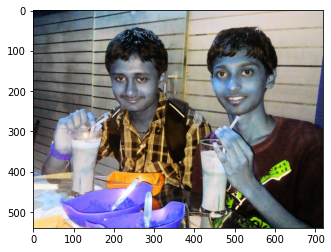

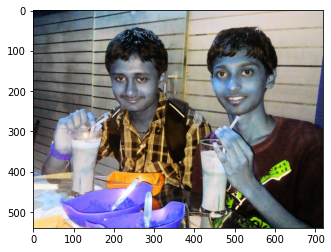

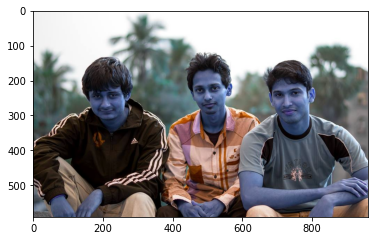

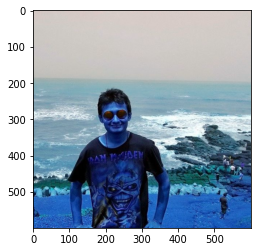

In [ ]:
args = np.argsort(result)
print("Query Image")
plt.imshow(image)
for idx, i in enumerate(args):
    print("Result: ", idx)
    plt.figure()
    plt.imshow(image_cpy[i])

# **Bounding Boxed Image**

In [ ]:
segbbox = SegmentationBboxGen()

None
['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
s = segbbox.generate_bbox_image(image)

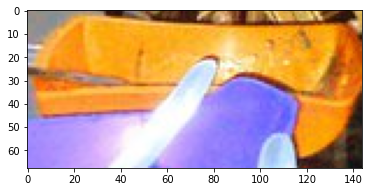

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(s[4]['bbox_img'])

In [ ]:
DATASET_CLASSES[s[-2]['pred_class']]

'cup'

## Segmented Image

In [ ]:
s = f.generate_segmentation_mask(image)

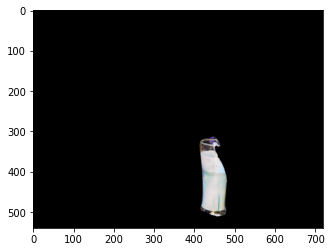